# Overfit and underfit
https://www.tensorflow.org/tutorials/keras/overfit_and_underfit

In [1]:
import tensorflow as tf
print("version", tf.__version__)
print("tf executing eagerly", tf.executing_eagerly())
print("GPU is", "available" if tf.config.list_physical_devices("GPU") else "not available")


version 2.3.0
tf executing eagerly True
GPU is available


In [2]:
!pip install -q git+https://github.com/tensorflow/docs

In [3]:
import tensorflow_docs 
from tensorflow_docs.plots import HistoryPlotter
from tensorflow_docs.modeling import EpochDots
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.regularizers import l2

In [4]:
from IPython import display
from matplotlib import pyplot as plt

import numpy as np
seed = 21

import pathlib
from pathlib import PosixPath, PurePosixPath
import shutil
import tempfile

In [5]:
logdir = pathlib.Path(tempfile.mkdtemp())/"tensorflow_logs"
shutil.rmtree(logdir, ignore_errors=True)

In [6]:
# Higgs dataset
gz = tf.keras.utils.get_file("HIGGS.csv.gz", 'http://mlphysics.ics.uci.edu/data/higgs/HIGGS.csv.gz')


In [7]:
FEATURES = 28
ds = tf.data.experimental.CsvDataset(gz,[float(),]*(FEATURES+1), compression_type="GZIP")

def pack_row(*row):
    label = row[0]
    features = tf.stack(row[1:],1)
    return features, label

packed_ds = ds.batch(10000).map(pack_row).unbatch()

tf.Tensor(
[ 0.8692932  -0.6350818   0.22569026  0.32747006 -0.6899932   0.75420225
 -0.24857314 -1.0920639   0.          1.3749921  -0.6536742   0.9303491
  1.1074361   1.1389043  -1.5781983  -1.0469854   0.          0.65792954
 -0.01045457 -0.04576717  3.1019614   1.35376     0.9795631   0.97807616
  0.92000484  0.72165745  0.98875093  0.87667835], shape=(28,), dtype=float32)


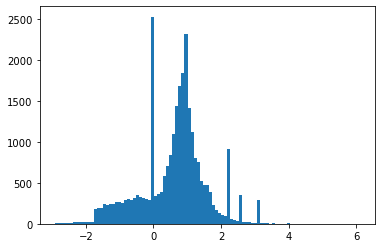

In [8]:
for features,label in packed_ds.batch(1000).take(1):
    print(features[0])
    plt.hist(features.numpy().flatten(), bins = 101)

In [9]:
N_VALIDATION = int(1e3)
N_TRAIN = int(1e4)
BUFFER_SIZE = int(1e4)
BATCH_SIZE = 500
STEPS_PER_EPOCH = N_TRAIN//BATCH_SIZE

In [10]:
validate_ds = packed_ds.take(N_VALIDATION).cache()
train_ds = packed_ds.skip(N_VALIDATION).take(N_TRAIN).cache()

In [11]:
validate_ds = validate_ds.batch(BATCH_SIZE)
train_ds = train_ds.shuffle(BUFFER_SIZE).repeat().batch(BATCH_SIZE)

In [12]:
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
                                          0.001,
                                          decay_steps=STEPS_PER_EPOCH*1000,
                                          decay_rate=1,
                                          staircase=False)

def get_optimizer():
    return tf.keras.optimizers.Adam(lr_schedule)

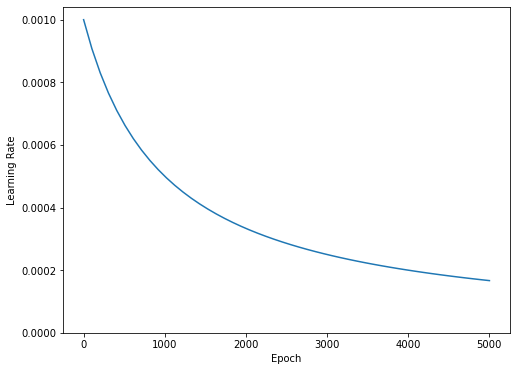

In [13]:
step = np.linspace(0,100000)
lr = lr_schedule(step)
plt.figure(figsize = (8,6))
plt.plot(step/STEPS_PER_EPOCH, lr)
plt.ylim([0,max(plt.ylim())])
plt.xlabel('Epoch')
_ = plt.ylabel('Learning Rate')

In [14]:
def get_callbacks(name):
    return([EpochDots(),
           EarlyStopping(monitor='val_binary_crossentropy', patience = 200),
           TensorBoard(logdir/name)])

In [15]:
def compile_and_fit(model, name, optimizer=None, max_epochs = 10000):
    if optimizer is None:
        optimizer = get_optimizer()
        model.compile(optimizer=optimizer, 
                     loss = BinaryCrossentropy(from_logits=True),
                     metrics = [BinaryCrossentropy(from_logits=True, 
                                                name='binary_crossentropy'), 
                                'accuracy'])
        model.summary()
        
        history = model.fit(train_ds,
                            steps_per_epoch = STEPS_PER_EPOCH, 
                            epochs = max_epochs, 
                            validation_data = validate_ds, 
                            callbacks=get_callbacks(name), 
                            verbose = 0)
        return history

In [16]:
# tiny model
tiny_model = tf.keras.Sequential([Dense(16, activation = 'elu', input_shape=(FEATURES,)),
                                 Dense(1)])

In [17]:
size_history = {}
size_history['Tiny'] = compile_and_fit(tiny_model, 'sizes/Tiny')

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                464       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 481
Trainable params: 481
Non-trainable params: 0
_________________________________________________________________
Instructions for updating:
use `tf.profiler.experimental.stop` instead.

Epoch: 0, accuracy:0.4848,  binary_crossentropy:0.7855,  loss:0.7855,  val_accuracy:0.4670,  val_binary_crossentropy:0.7491,  val_loss:0.7491,  
....................................................................................................
Epoch: 100, accuracy:0.5772,  binary_crossentropy:0.6351,  loss:0.6351,  val_accuracy:0.5530,  val_binary_crossentropy:0.6352,  val_loss:0.6352,  
......................................................

....................................................................................................
Epoch: 2900, accuracy:0.6804,  binary_crossentropy:0.5723,  loss:0.5723,  val_accuracy:0.6700,  val_binary_crossentropy:0.5847,  val_loss:0.5847,  
....................................................................................................
Epoch: 3000, accuracy:0.6791,  binary_crossentropy:0.5714,  loss:0.5714,  val_accuracy:0.6670,  val_binary_crossentropy:0.5853,  val_loss:0.5853,  
....................................................................................................
Epoch: 3100, accuracy:0.6810,  binary_crossentropy:0.5715,  loss:0.5715,  val_accuracy:0.6840,  val_binary_crossentropy:0.5836,  val_loss:0.5836,  
....................................................................................................
Epoch: 3200, accuracy:0.6773,  binary_crossentropy:0.5709,  loss:0.5709,  val_accuracy:0.6830,  val_binary_crossentropy:0.5832,  val_loss:0.5832,  
....

(0.5, 0.7)

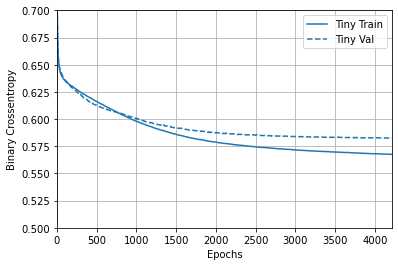

In [18]:
plotter = HistoryPlotter(metric='binary_crossentropy', smoothing_std=10)
plotter.plot(size_history)
plt.ylim([0.5,0.7])

In [19]:
# small model
small_model = tf.keras.Sequential([Dense(16, activation='elu', input_shape=(FEATURES,)),
                                  Dense(16, activation='elu'),
                                  Dense(1)])
size_history['Small'] = compile_and_fit(small_model,'sizes/Small')

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 16)                464       
_________________________________________________________________
dense_3 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 17        
Total params: 753
Trainable params: 753
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.4785,  binary_crossentropy:1.0605,  loss:1.0605,  val_accuracy:0.4740,  val_binary_crossentropy:0.8078,  val_loss:0.8078,  
....................................................................................................
Epoch: 100, accuracy:0.6192,  binary_crossentropy:0.6197,  loss:0.6197,  val_accuracy:0.5840,  val_binary_crossentropy:0.6161,  val_loss:0.

In [20]:
# medium model
medium_model = tf.keras.Sequential([
    Dense(64, activation='elu', input_shape=(FEATURES,)),
    Dense(64, activation='elu'),
    Dense(64, activation='elu'),
    Dense(1)
])

size_history['Medium']  = compile_and_fit(medium_model, "sizes/Medium")

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 64)                1856      
_________________________________________________________________
dense_6 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_7 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 65        
Total params: 10,241
Trainable params: 10,241
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.4882,  binary_crossentropy:0.6985,  loss:0.6985,  val_accuracy:0.4700,  val_binary_crossentropy:0.6837,  val_loss:0.6837,  
....................................................................................................
E

In [21]:
# large model
large_model = tf.keras.Sequential([
    Dense(512, activation='elu', input_shape=(FEATURES,)),
    Dense(512, activation='elu'),
    Dense(512, activation='elu'),
    Dense(512, activation='elu'),
    Dense(1)
])

size_history['large'] = compile_and_fit(large_model, "sizes/large")

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 512)               14848     
_________________________________________________________________
dense_10 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_11 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_12 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 513       
Total params: 803,329
Trainable params: 803,329
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.5054,  binary_crossentropy:0.8067,  loss:0.8067,  val_accuracy:0.5560,  val_binary_crossentr

Text(0.5, 0, 'Epochs [Log Scale]')

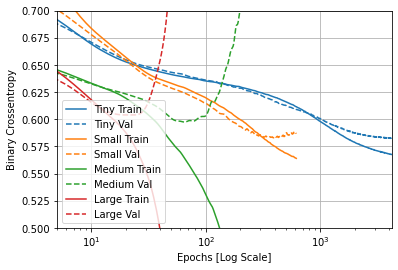

In [22]:
plotter.plot(size_history)
a = plt.xscale('log')
plt.xlim([5, max(plt.xlim())])
plt.ylim([0.5, 0.7])
plt.xlabel("Epochs [Log Scale]")

plt.Text(0.5, 0, 'Epochs [Log Scale]')

In [23]:
# view in tensorboard
# Load the TensorBoard notebook extension
# %load_ext tensorboard

# Open an embedded TensorBoard viewer
# %tensorboard --logdir {logdir}/sizes

In [24]:
display.IFrame(
    src="https://tensorboard.dev/experiment/vW7jmmF9TmKmy3rbheMQpw/#scalars&_smoothingWeight=0.97",
    width="100%", height="800px")

In [25]:
# tensorboard dev upload --logdir {logdir}/sizes

# Strategies to prevent overfitting

### 1-regularization

In [26]:
shutil.rmtree(logdir/'regularizers/Tiny', ignore_errors=True)
shutil.copytree(logdir/'sizes/Tiny', logdir/'regularizers/Tiny')

PurePosixPath('/tmp/tmpnnkr5005/tensorboard_logs/regularizers/Tiny')

regularizer_histories = {}
regularizer_histories['Tiny'] = size_history['Tiny']

In [27]:
l2_model = tf.keras.Sequential([
    Dense(512, activation='elu',kernel_regularizer=l2(0.001),
          input_shape=(FEATURES,)),
    Dense(512, activation='elu',kernel_regularizer=l2(0.001)),
    Dense(512, activation='elu',kernel_regularizer=l2(0.001)),
    Dense(512, activation='elu',kernel_regularizer=l2(0.001)),
    Dense(1)
])

regularizer_histories['l2'] = compile_and_fit(l2_model, "regularizers/l2")

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_14 (Dense)             (None, 512)               14848     
_________________________________________________________________
dense_15 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_16 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_17 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 513       
Total params: 803,329
Trainable params: 803,329
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.5116,  binary_crossentropy:0.8232,  loss:2.3490,  val_accuracy:0.4710,  val_binary_crossentr

In [28]:
plotter.plt(regularizer_histories)
plt.ylim([0.5,0.7])

AttributeError: 'HistoryPlotter' object has no attribute 'plt'

In [29]:
result = l2_model(features)
regularization_loss=tf.add_n(l2_model.losses)

### 2- dropout

In [30]:
dropout_model = tf.keras.Sequential([
    Dense(512, activation='elu', input_shape=(FEATURES,)),
    Dropout(0.5),
    Dense(512, activation='elu'),
    Dropout(0.5),
    Dense(512, activation='elu'),
    Dropout(0.5),
    Dense(512, activation='elu'),
    Dropout(0.5),
    Dense(1)
])

regularizer_histories['dropout'] = compile_and_fit(dropout_model, "regularizers/dropout")

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_19 (Dense)             (None, 512)               14848     
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_21 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 512)              

(0.5, 0.7)

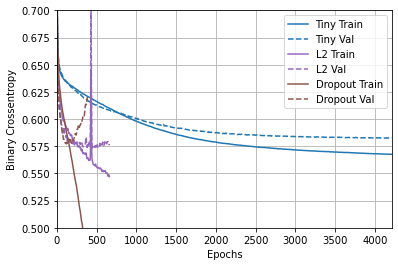

In [31]:
plotter.plot(regularizer_histories)
plt.ylim([0.5, 0.7])

### l2 + dropout

In [32]:
combined_model = tf.keras.Sequential([
    Dense(512, kernel_regularizer=l2(0.0001),
                 activation='elu', input_shape=(FEATURES,)),
    Dropout(0.5),
    Dense(512, kernel_regularizer=l2(0.0001),
                 activation='elu'),
    Dropout(0.5),
    Dense(512, kernel_regularizer=l2(0.0001),
                 activation='elu'),
    Dropout(0.5),
    Dense(512, kernel_regularizer=l2(0.0001),
                 activation='elu'),
    Dropout(0.5),
    Dense(1)
])

regularizer_histories['combined'] = compile_and_fit(combined_model, "regularizers/combined")

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_24 (Dense)             (None, 512)               14848     
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_25 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_5 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_26 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_6 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_27 (Dense)             (None, 512)              

(0.5, 0.7)

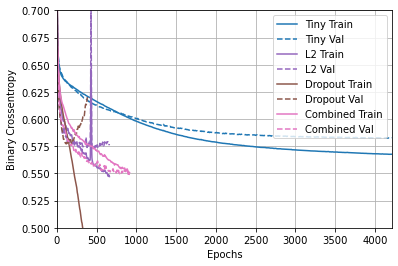

In [33]:
plotter.plot(regularizer_histories)
plt.ylim([0.5, 0.7])

In [34]:
# tensorboard
# %tensorboard --logdir {logdir}/regularizers

In [35]:
display.IFrame(
    src="https://tensorboard.dev/experiment/fGInKDo8TXes1z7HQku9mw/#scalars&_smoothingWeight=0.97",
    width = "100%",
    height="800px")

efficient ways to prevent overfitting:
- Get more training data.
- Reduce the capacity of the network.
- Add weight regularization.
- Add dropout.
- data-augmentation
- batch normalization